# 🛰️ SAR Waterbody Segmentation

## Group: AI_S1

### Project Objective
Semantic segmentation of waterbodies using Synthetic Aperture Radar (SAR) imagery with a U-Net deep learning architecture.

### Key Components
- Dataset: KOMPSAT-5 (Korean Multi-purpose Satellite 5) is a satellite that provides high-resolution SAR images of the Earth's surface.
- Model: U-Net Convolutional Neural Network
- Task: Binary segmentation of water regions

## 0. Imports and Setup 🛠️


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import random
import datetime
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Using standard tqdm to avoid IProgress issues
from scipy import stats
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

from scipy import ndimage
from skimage import filters, morphology, exposure



print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


## 1. Dataset Exploration and Preprocessing 📊

In [4]:
 # Define paths for images and masks
base_path = os.path.join(os.getcwd(), '..', 'data')

img_path = os.path.join(base_path, 'images')
mask_path = os.path.join(base_path, 'masks')

# Get sorted list of image and mask files
img_files = sorted(glob.glob(os.path.join(img_path, '*.tif')))
mask_files = sorted(glob.glob(os.path.join(mask_path, '*.tif')))


In [5]:
def explore_dataset(base_path):
    """
    Comprehensive data exploration function for image segmentation dataset
    """

    # Basic dataset info
    print("=== Dataset Overview ===")
    print(f"Total images found: {len(img_files)}")
    print(f"Total masks found: {len(mask_files)}")

    # Calculate and display statistics
    stats_data = calculate_dataset_statistics(img_files, mask_files)
    visualize_dataset_statistics(stats_data)

    # Display sample images with analysis
    visualize_sample_images(img_files, mask_files)

    # Show mask distribution analysis
    analyze_mask_distribution(mask_files)

    return img_files, mask_files, stats_data

def calculate_dataset_statistics(img_files, mask_files):
    """Calculate comprehensive statistics for the dataset"""
    stats_data = {
        'image_sizes': [],
        'mask_sizes': [],
        'mask_coverage': [],
        'aspect_ratios': [],
        'class_distribution': []
    }

    print("\n=== Calculating Dataset Statistics ===")
    for img_file, mask_file in tqdm(zip(img_files, mask_files), total=len(img_files)):
        # Load images
        img = np.array(Image.open(img_file))
        mask = np.array(Image.open(mask_file))

        # Image sizes and aspect ratios
        stats_data['image_sizes'].append(img.shape)
        stats_data['mask_sizes'].append(mask.shape)
        stats_data['aspect_ratios'].append(img.shape[1] / img.shape[0])

        # Mask coverage
        total_pixels = mask.size
        mask_pixels = np.sum(mask > 0)
        coverage = (mask_pixels / total_pixels) * 100
        stats_data['mask_coverage'].append(coverage)

        # Class distribution (binary for segmentation)
        unique, counts = np.unique(mask, return_counts=True)
        stats_data['class_distribution'].append(dict(zip(unique, counts)))

    return stats_data

def visualize_dataset_statistics(stats_data):
    """Visualize various statistics of the dataset"""
    plt.figure(figsize=(20, 10))

    # 1. Mask Coverage Distribution
    plt.subplot(1, 2, 1)
    sns.histplot(stats_data['mask_coverage'])
    plt.title('Mask Coverage Distribution')
    plt.xlabel('Coverage Percentage')
    plt.ylabel('Count')

    

def visualize_sample_images(img_files, mask_files):
    """Visualize sample images and their corresponding masks"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for idx in range(min(len(img_files), 9)):
        img = np.array(Image.open(img_files[idx]))
        mask = np.array(Image.open(mask_files[idx]))

        # Original Image
        axes[idx // 3, idx % 3].imshow(img, cmap='gray')
        overlay = np.zeros_like(img)
        overlay[mask > 0] = 255
        axes[idx // 3, idx % 3].imshow(overlay, alpha=0.3, cmap='Reds')
        axes[idx // 3, idx % 3].set_title(f'Sample {idx+1}')
        axes[idx // 3, idx % 3].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_mask_distribution(mask_files):
    """Analyze mask distribution and characteristics"""
    water_pixels = []
    total_pixels = []

    for mask_file in tqdm(mask_files):
        mask = np.array(Image.open(mask_file))
        total_pixels.append(mask.size)
        water_pixels.append(np.sum(mask > 0))

    # Display results
    print("\n=== Mask Distribution Analysis ===")
    print(f"Average Mask Pixel Percentage: {np.mean(np.array(water_pixels) / np.array(total_pixels)) * 100:.2f}%")
    print(f"Total Mask Pixels: {np.sum(water_pixels):,}")
    print(f"Total Pixels: {np.sum(total_pixels):,}")


=== Dataset Overview ===
Total images found: 1860
Total masks found: 1860

=== Calculating Dataset Statistics ===


100%|██████████| 1860/1860 [01:37<00:00, 19.03it/s]


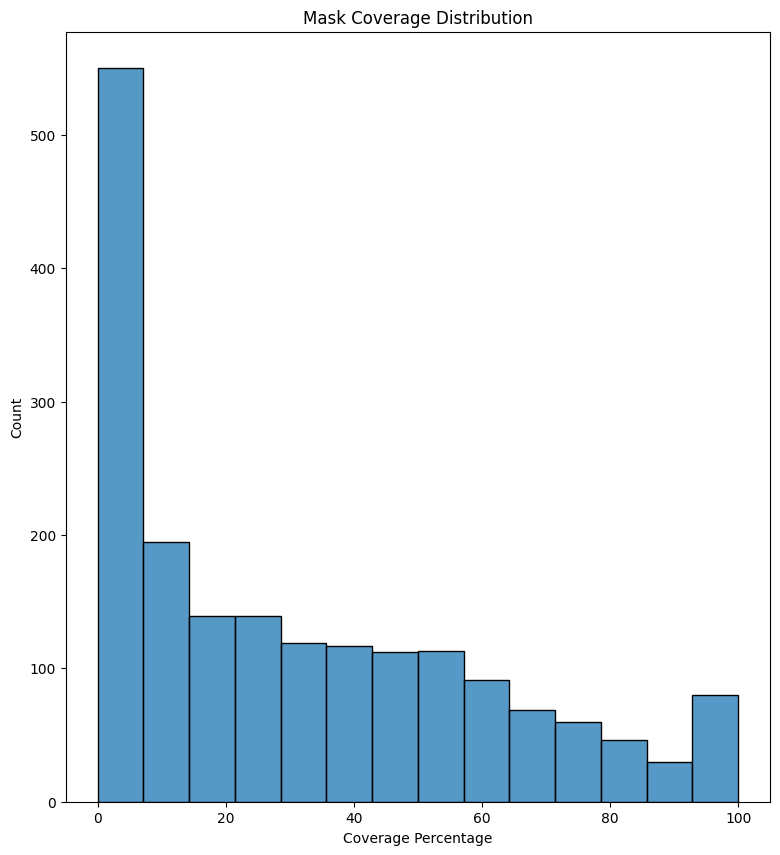

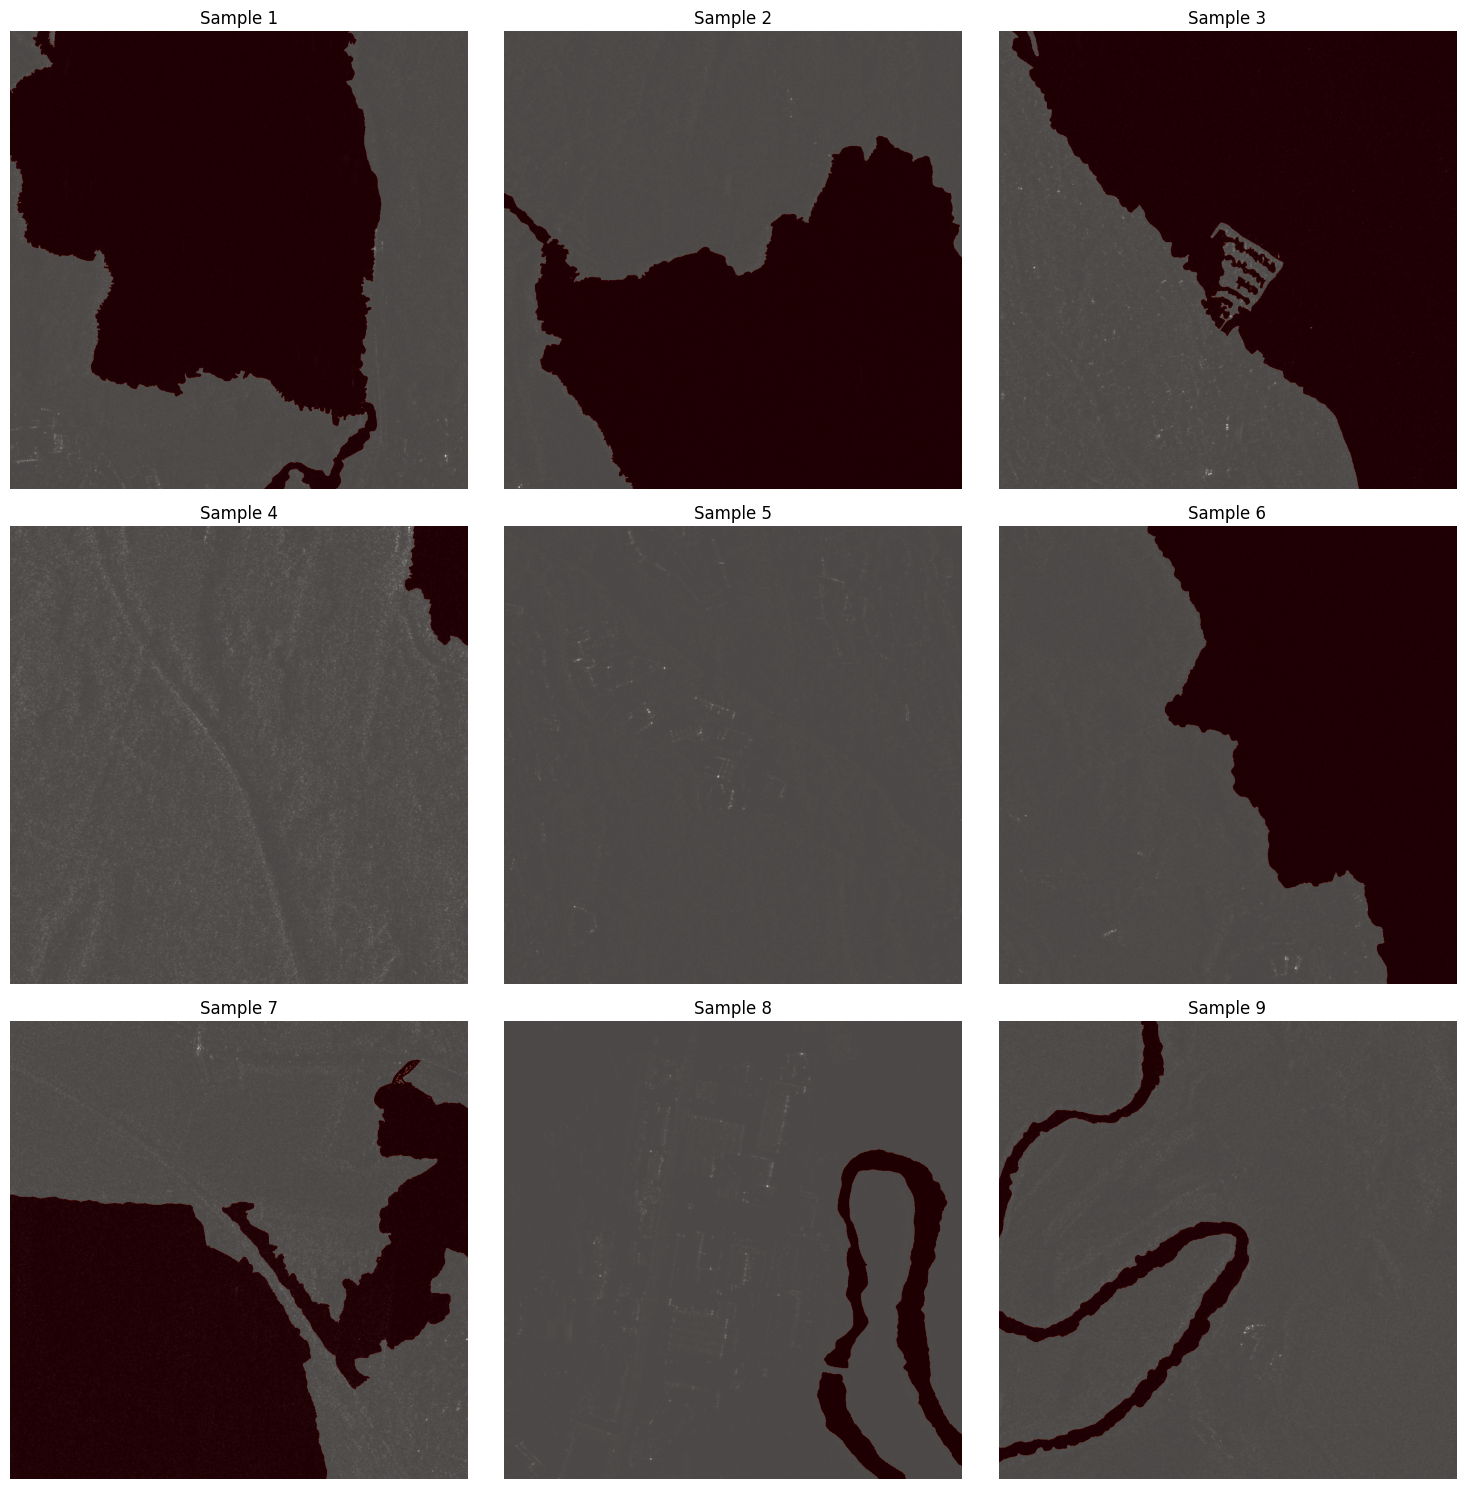

100%|██████████| 1860/1860 [00:13<00:00, 136.74it/s]


=== Mask Distribution Analysis ===
Average Mask Pixel Percentage: 31.20%
Total Mask Pixels: 608,469,784
Total Pixels: 1,950,351,360

Sample Returned Data:
First Image File: d:\sar_waterbody_segmentation\notebooks\..\data\images\WTR00001_K5_NIA0184.tif
First Mask File: d:\sar_waterbody_segmentation\notebooks\..\data\masks\WTR00001_K5_NIA0184_label.tif
Dataset Statistics: {'image_sizes': [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 

In [6]:
img_files, mask_files, stats_data = explore_dataset(base_path)

# Access returned data
print("\nSample Returned Data:")
print(f"First Image File: {img_files[0]}")
print(f"First Mask File: {mask_files[0]}")
print(f"Dataset Statistics: {stats_data}")


In [7]:

class DatasetAnalyzer:
    def __init__(self, base_path):
        self.base_path = base_path
        self.img_path = os.path.join(base_path, 'images')
        self.mask_path = os.path.join(base_path, 'masks')
        
    def explore_dataset(self):
        """Comprehensive dataset exploration"""
        img_files = sorted(glob.glob(os.path.join(self.img_path, '*.tif')))
        mask_files = sorted(glob.glob(os.path.join(self.mask_path, '*.tif')))
        
        # Dataset Statistics
        dataset_stats = {
            'Image Dimensions': [np.array(Image.open(f)).shape for f in img_files[:5]],
        }
        
        # Visualization
        self._visualize_dataset_samples(img_files, mask_files)
        
        return img_files, mask_files, dataset_stats
    
    
    def _visualize_dataset_samples(self, img_files, mask_files):
        """Visualize dataset samples with statistics"""
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        plt.suptitle('SAR Waterbody Dataset Sample Visualization', fontsize=16)
        
        for idx, (img_path, mask_path) in enumerate(zip(img_files[:9], mask_files[:9])):
            row = idx // 3
            col = idx % 3
            
            img = np.array(Image.open(img_path))
            mask = np.array(Image.open(mask_path))
            
            # Original Image
            axes[row, col].imshow(img, cmap='gray')
            water_percent = np.mean(mask > 0) * 100
            axes[row, col].set_title(f'Sample {idx+1}\nWater: {water_percent:.2f}%')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        


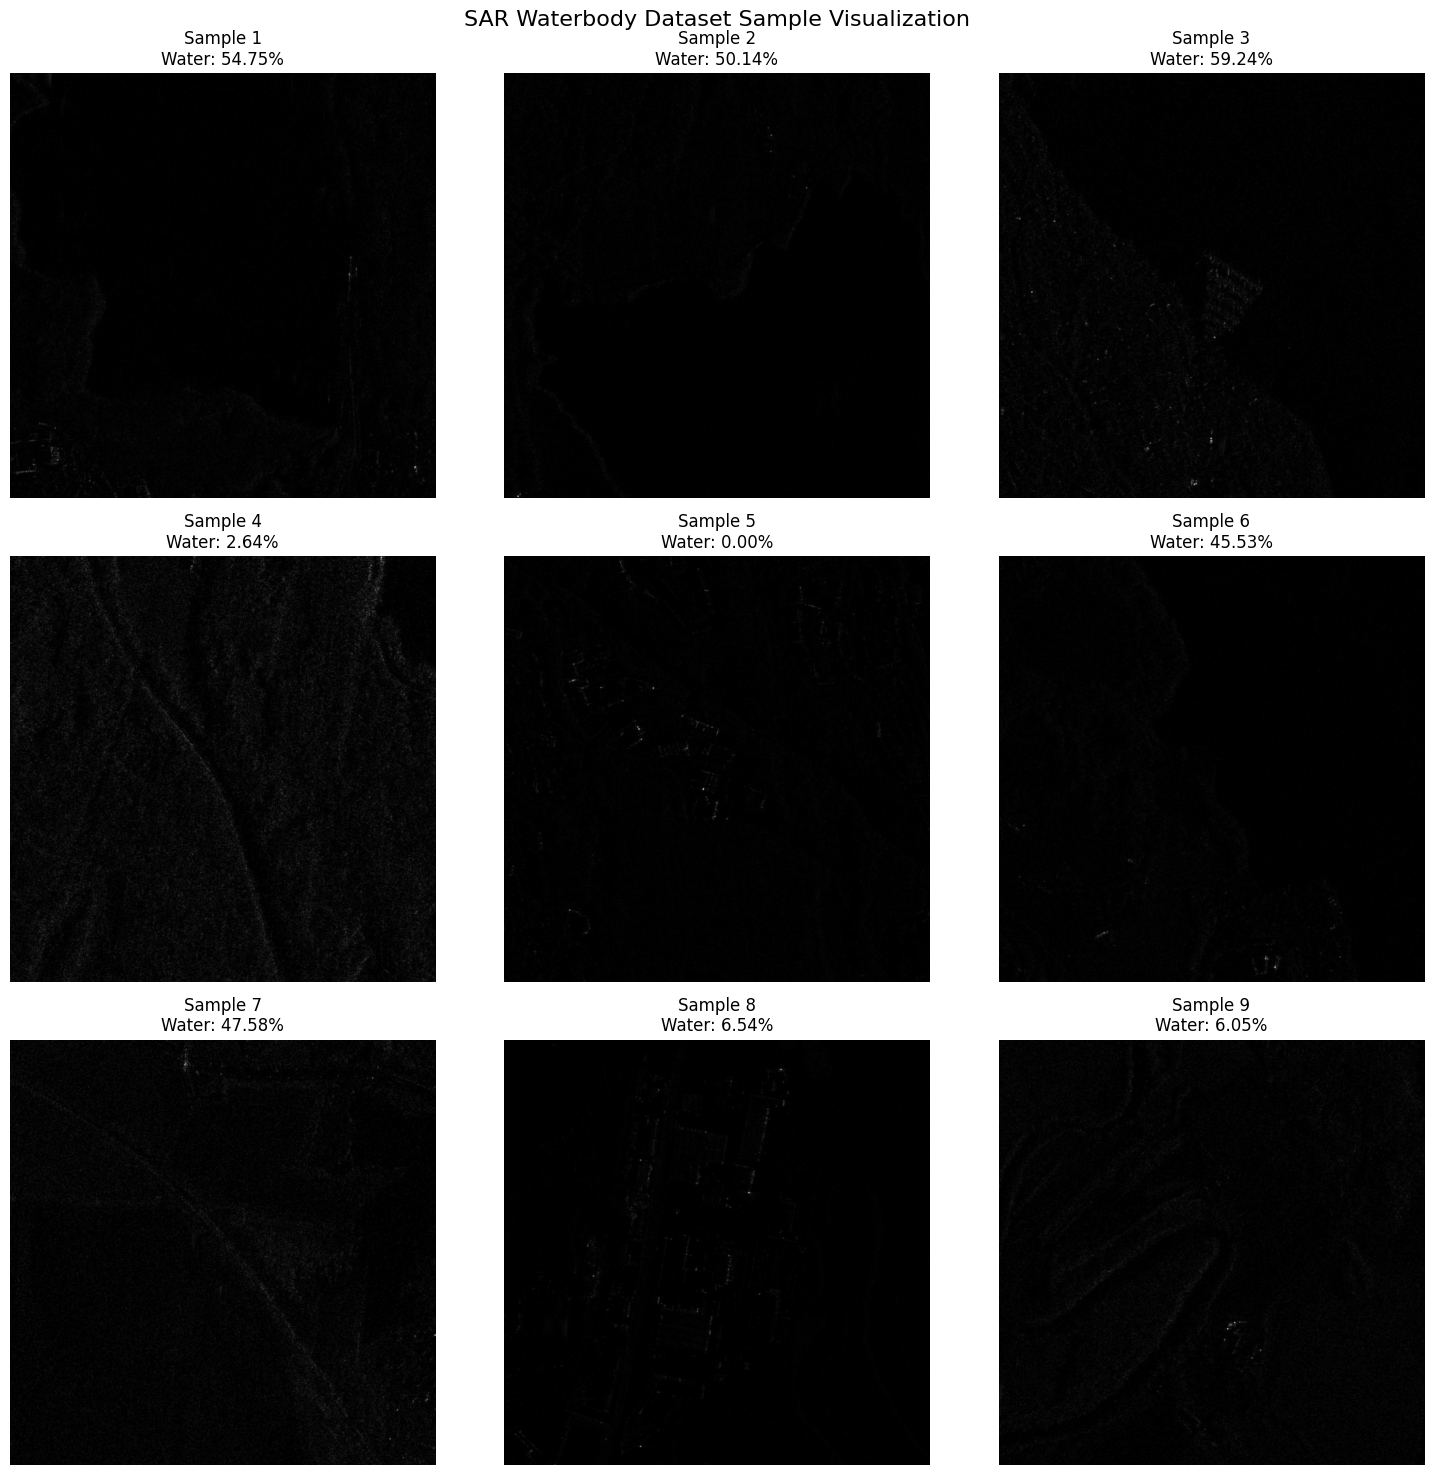


Dataset Statistics:
Image Dimensions: [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]


In [8]:
# Initialize and use DatasetAnalyzer
analyzer = DatasetAnalyzer(base_path)
img_files, mask_files, dataset_stats = analyzer.explore_dataset()

print("\nDataset Statistics:")
for key, value in dataset_stats.items():
    print(f"{key}: {value}")


In [9]:
def data_generator(img_files, mask_files, batch_size=8, target_size=(256, 256)):
    """Yield batches of images and masks for memory efficiency."""
    while True:
        for start in range(0, len(img_files), batch_size):
            end = min(start + batch_size, len(img_files))
            images, masks = [], []
            for img_path, mask_path in zip(img_files[start:end], mask_files[start:end]):
                # Load and preprocess image and mask
                img = np.array(Image.open(img_path).resize(target_size)).astype('float32') / 255.0
                mask = np.array(Image.open(mask_path).resize(target_size)).astype('float32') / 255.0
                
                img = np.expand_dims(img, axis=-1) if img.ndim == 2 else img
                mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask
                
                images.append(img)
                masks.append(mask)
                
            yield np.array(images), np.array(masks)

In [10]:
def build_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = layers.Concatenate()([conv4, up6])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([conv3, up7])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([conv2, up8])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([conv1, up9])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [70]:
@tf.function
def iou_metric(y_true, y_pred):
    # Convert predictions to binary
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    # Add epsilon to avoid division by zero
    return intersection / (union + tf.keras.backend.epsilon())

In [12]:
# Build your U-Net model
model = build_unet()

# Compile the model with a custom IoU metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_7[0][0], 

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Cell 12 - Code [Training]
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'unet_new_model.keras',
    monitor='val_loss',
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [14]:
batch_size = 8

# Splitting the data
train_size = int(0.7 * len(img_files))
val_size = int(0.1 * len(img_files))  # 10% for validation
test_size = len(img_files) - train_size - val_size  # Remaining 10% for testing

# Training set
train_gen = data_generator(img_files[:train_size], mask_files[:train_size], batch_size=batch_size)

# Validation set
val_gen = data_generator(
    img_files[train_size:train_size + val_size],
    mask_files[train_size:train_size + val_size],
    batch_size=batch_size
)

# Test set
test_gen = data_generator(
    img_files[train_size + val_size:],
    mask_files[train_size + val_size:],
    batch_size=batch_size
)


In [17]:

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(img_files) // batch_size,
    validation_steps=len(img_files) // batch_size,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2191s 9s/step - accuracy: 0.8778 - iou_metric: 0.6298 - loss: 0.3103 - val_accuracy: 0.9426 - val_iou_metric: 0.6016 - val_loss: 0.1465
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2204s 10s/step - accuracy: 0.8774 - iou_metric: 0.6523 - loss: 0.3283 - val_accuracy: 0.9432 - val_iou_metric: 0.6531 - val_loss: 0.4630
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2182s 9s/step - accuracy: 0.8658 - iou_metric: 0.6239 - loss: 0.3446 - val_accuracy: 0.9392 - val_iou_metric: 0.6459 - val_loss: 0.2241
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2184s 9s/step - accuracy: 0.8935 - iou_metric: 0.6605 - loss: 0.2721 - val_accuracy: 0.9470 - val_iou_metric: 0.6323 - val_loss: 0.1292
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2179s 9s/step - accuracy: 0.8546 - iou_metric: 0.6331 - loss: 0.3956 - val_accuracy: 0.9468 - val_iou_metric: 0.6495 - val_loss: 0.1425
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2188s 9s/step - accuracy: 0.8871 - iou_metric: 0.6538 - loss: 0.2810 - val_accu

In [18]:
test_steps = len(img_files[train_size + val_size:]) // batch_size
test_loss, test_acc, test_iou, = model.evaluate(test_gen, steps=test_steps)
print(f"\nTest Accuracy: {test_acc:.4f}")



46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8338 - iou_metric: 0.6338 - loss: 0.3590

Test Accuracy: 0.8286


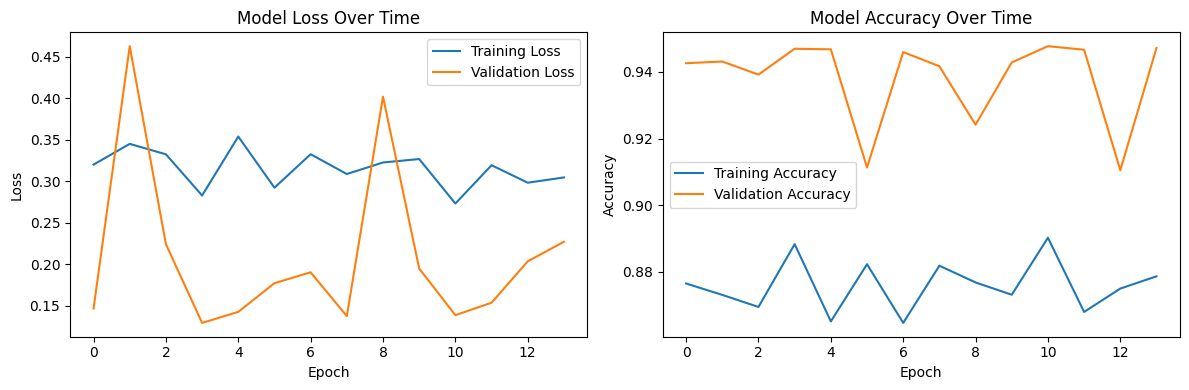

In [22]:
# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import confusion_matrix

def evaluate_metrics(y_true, y_pred_binary):
    """
    Evaluate various metrics based on the binary ground truth and predictions.

    Parameters:
        y_true (np.ndarray): Ground truth binary masks.
        y_pred_binary (np.ndarray): Predicted binary masks.

    Returns:
        dict: Dictionary containing various metrics.
    """
    metrics = {}
    
    # Accuracy
    metrics["accuracy"] = accuracy_score(y_true, y_pred_binary)
    
    # Precision
    metrics["precision"] = precision_score(y_true, y_pred_binary, average='binary')
    
    # Recall
    metrics["recall"] = recall_score(y_true, y_pred_binary, average='binary')
    
    # F1-Score
    metrics["f1_score"] = f1_score(y_true, y_pred_binary, average='binary')
    
    # Dice Coefficient (same as F1 score for binary classification)
    metrics["dice_coefficient"] = f1_score(y_true, y_pred_binary, average='binary')
    
    # Intersection over Union (IoU)
    metrics["iou"] = jaccard_score(y_true, y_pred_binary, average='binary')
    
    
    
    # Confusion Matrix
    cm = confusion_matrix(y_true.flatten(), y_pred_binary.flatten())
    metrics["confusion_matrix"] = cm.tolist()  # Convert to list for readability
    
    return metrics

# Ensure predictions and true labels are binary and flattened
y_pred_binary = (y_pred >= 0.5).astype(int)  # Threshold predictions to binary
y_true_flat = y_true.flatten().astype(int)  # Ground truth (binary, flattened)
y_pred_flat = y_pred_binary.flatten().astype(int)  # Predicted (binary, flattened)

#
# Evaluate metrics
metrics = evaluate_metrics(y_true_flat, y_pred_flat)

# Print metrics
for key, value in metrics.items():
    if key == "confusion_matrix":
        print(f"{key}:\n{np.array(value)}")
    else:
        print(f"{key}: {value}")


accuracy: 0.8549346513645624
precision: 0.8994551437986752
recall: 0.6783728296363427
f1_score: 0.7734251658643194
dice_coefficient: 0.7734251658643194
iou: 0.6305568517630006
confusion_matrix:
[[14806593   674751]
 [ 2861854  6036194]]


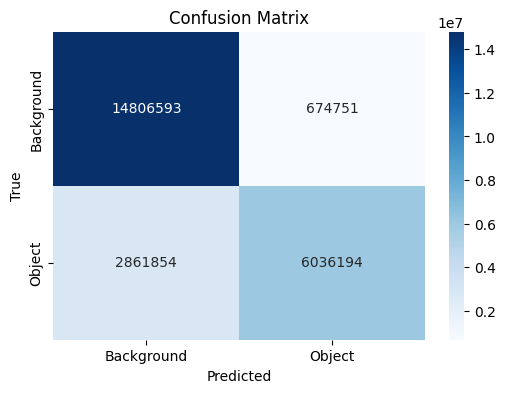

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plot a confusion matrix as a heatmap.
    
    Parameters:
        cm (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"], class_names=["Background", "Object"])


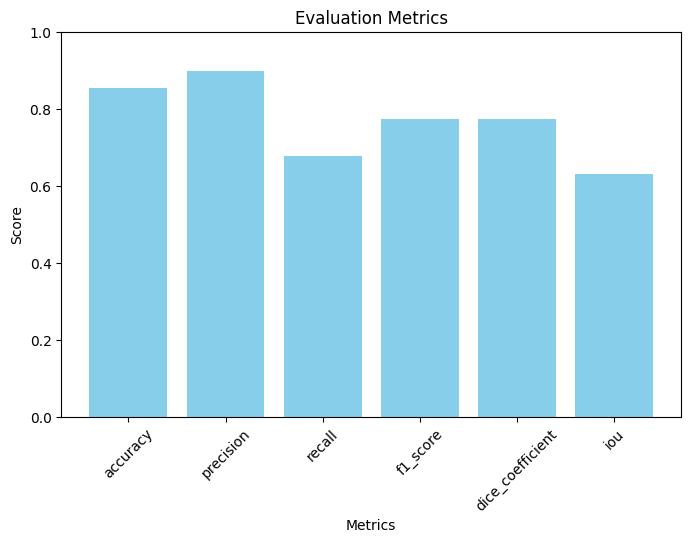

In [32]:
def plot_metrics(metrics):
    """
    Plot metrics as a bar chart.
    
    Parameters:
        metrics (dict): Dictionary of metrics.
    """
    # Exclude confusion matrix from plotting
    metrics_to_plot = {k: v for k, v in metrics.items() if k != "confusion_matrix"}
    
    plt.figure(figsize=(8, 5))
    plt.bar(metrics_to_plot.keys(), metrics_to_plot.values(), color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Metrics are between 0 and 1
    plt.show()

# Plot metrics
plot_metrics(metrics)



Visualizing predictions on random test samples:


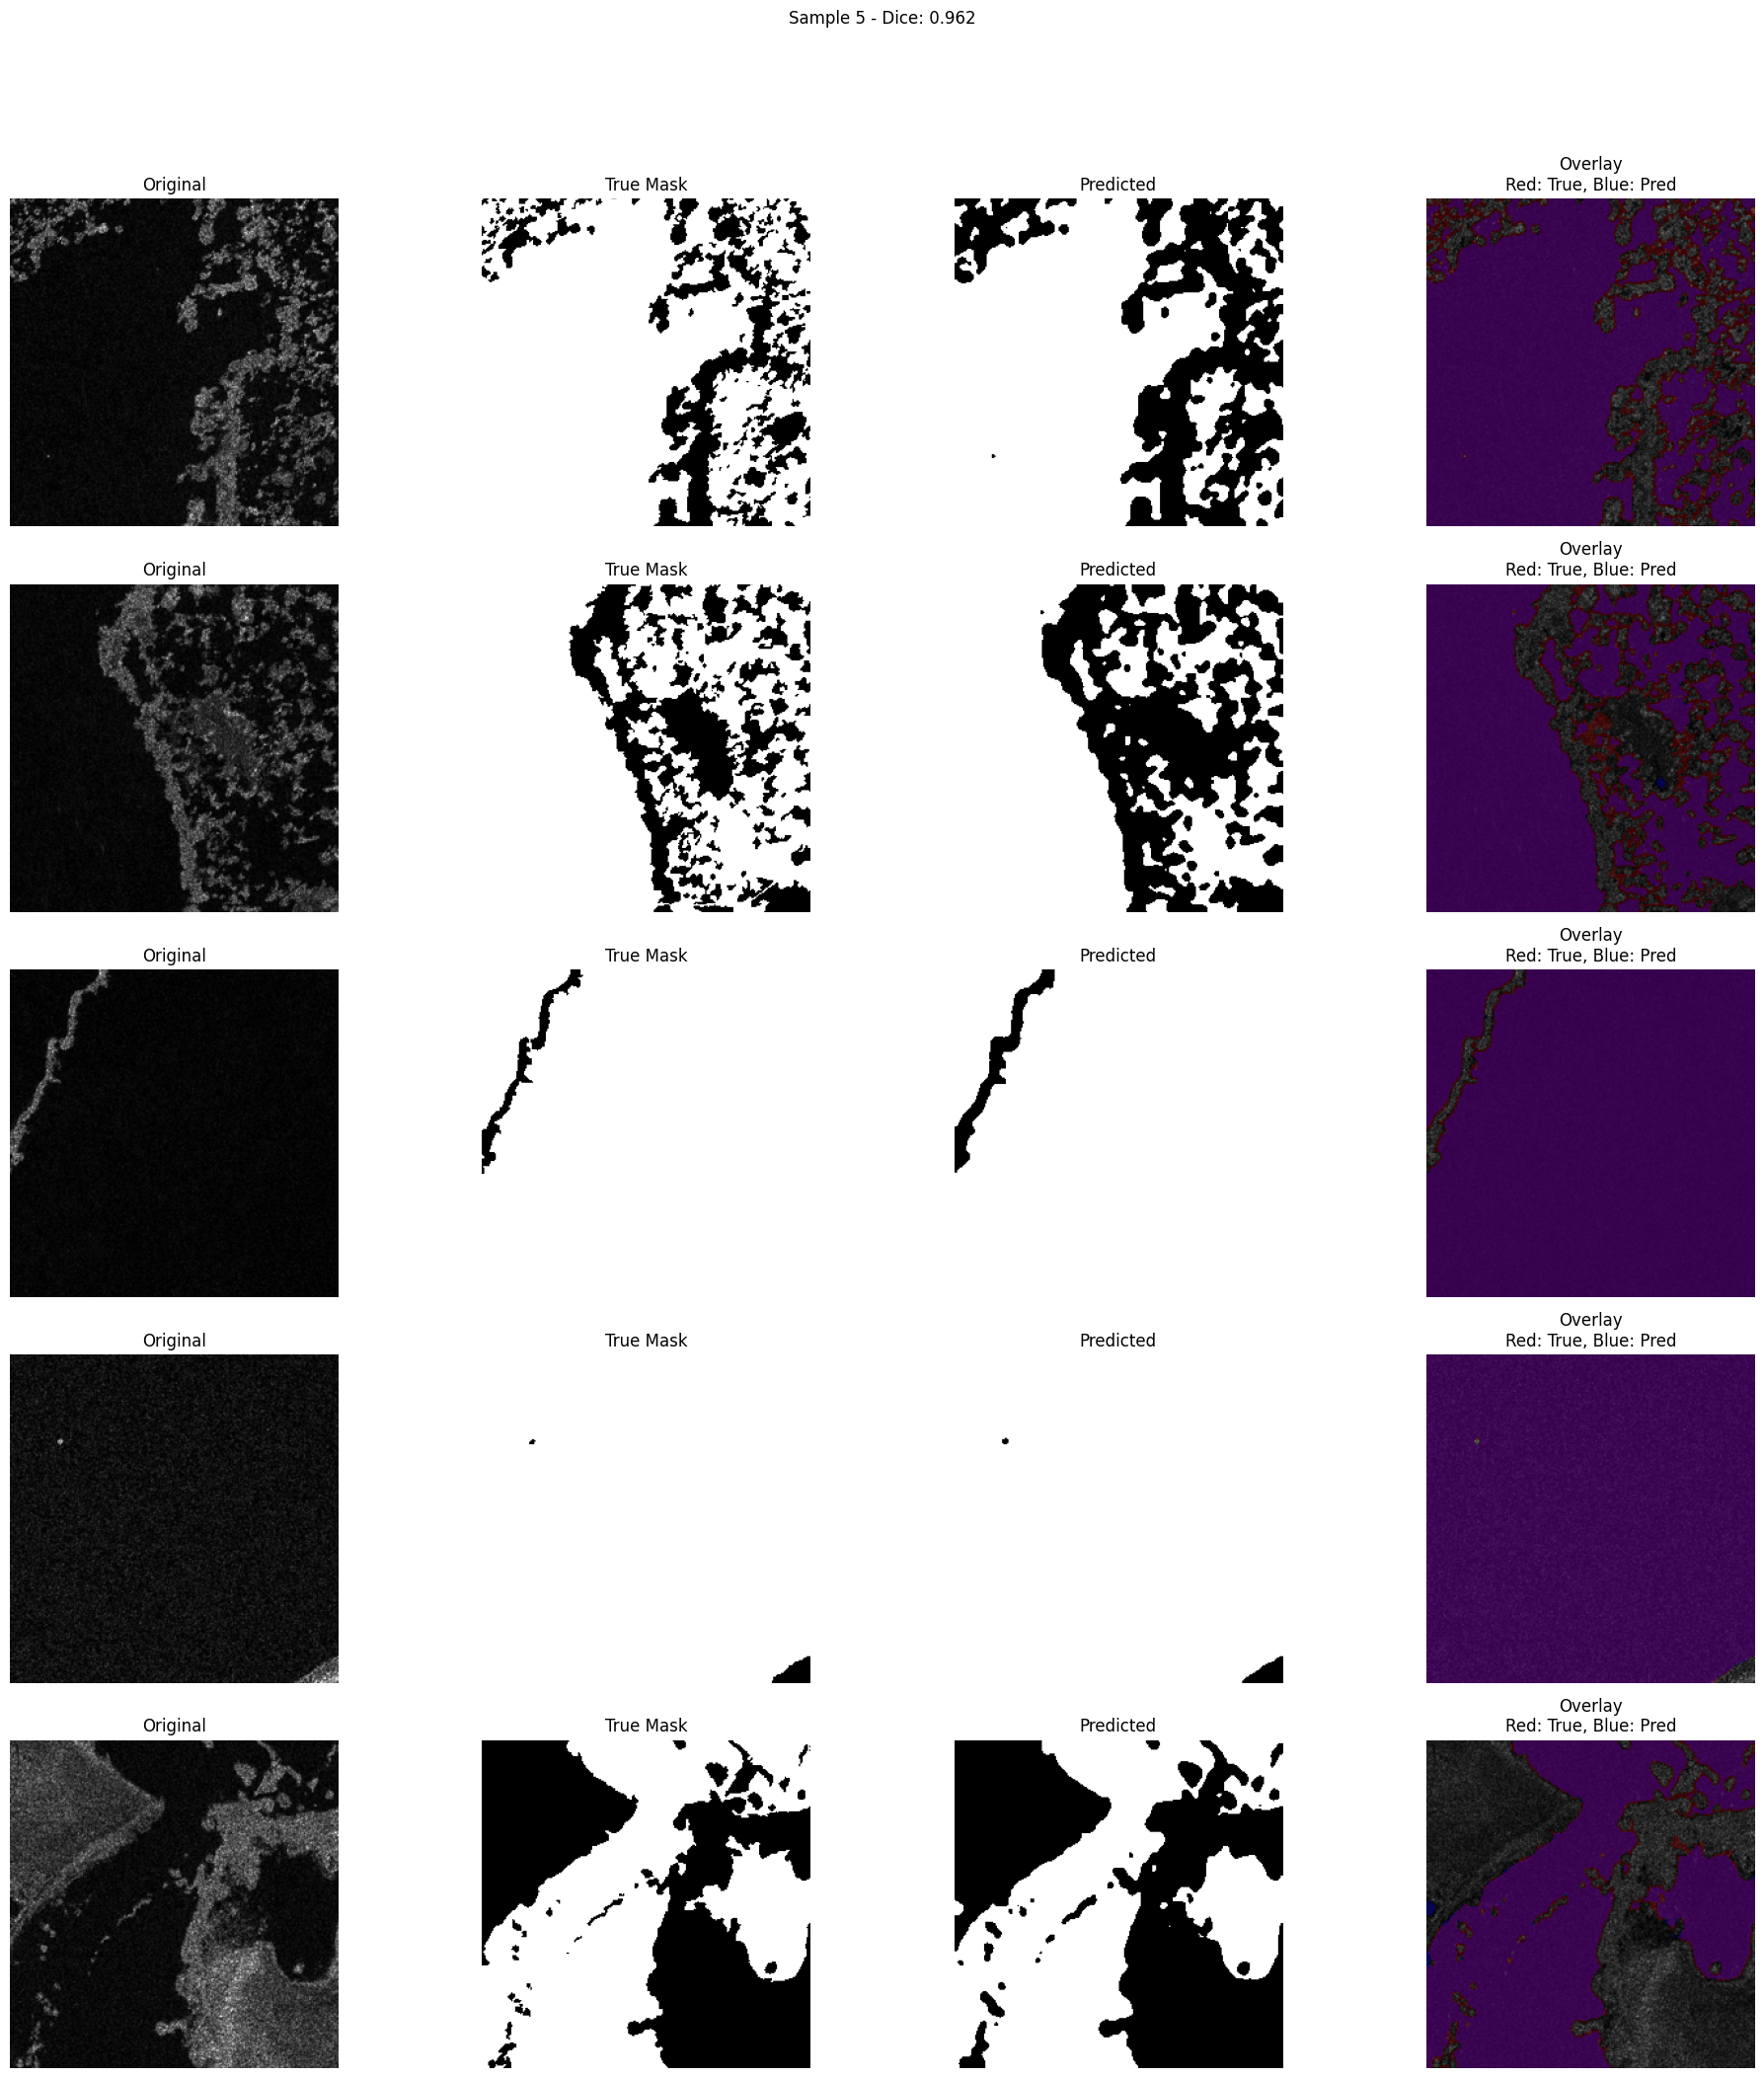

In [45]:
def visualize_predictions(model, test_gen, num_samples=5):
    
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Get a batch of data from the test generator
    X_test, y_true = next(test_gen)
    
    # Ensure we have enough samples in the batch for visualization
    num_samples = min(num_samples, len(X_test))
    
    plt.figure(figsize=(20, 4*num_samples))
    
    for idx in range(num_samples):
        img = X_test[idx]  # Image from the generator batch
        mask = y_true[idx]  # Ground truth mask from the generator batch
        
        # Ensure mask is binary and has the same number of channels as image
        mask = (mask > 0.5).astype(np.float32)
        
        # If the image has multiple channels (e.g., RGB), ensure the mask has a single channel
        if img.ndim == 3 and mask.ndim == 2:  # img is RGB and mask is grayscale
            mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension to the mask
        
        img_input = np.expand_dims(img, axis=0)  # Expanding to batch dimension
        if img_input.ndim == 3:  # For grayscale images (if applicable)
            img_input = np.expand_dims(img_input, axis=-1)
        
        # Get prediction and convert to binary
        pred = model.predict(img_input, verbose=0)[0, :, :, 0]
        pred_binary = (pred > 0.5).astype(np.float32)
        
        # Four panel display
        plt.subplot(num_samples, 4, idx*4 + 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, idx*4 + 2)
        plt.imshow(mask[:, :, 0], cmap='gray')  # Make sure to display the single channel of the mask
        plt.title('True Mask')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, idx*4 + 3)
        plt.imshow(pred_binary, cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
        
        # Overlay comparison
        plt.subplot(num_samples, 4, idx*4 + 4)
        plt.imshow(img, cmap='gray')
        
        # Create RGB overlays
        mask_overlay = np.zeros((*pred_binary.shape, 3))
        mask_overlay[mask[:, :, 0] > 0.5] = [1, 0, 0]  # Red for true mask
        
        pred_overlay = np.zeros((*pred_binary.shape, 3))
        pred_overlay[pred_binary > 0.5] = [0, 0, 1]  # Blue for prediction
        
        plt.imshow(mask_overlay, alpha=0.3)
        plt.imshow(pred_overlay, alpha=0.3)
        plt.title('Overlay\nRed: True, Blue: Pred')
        plt.axis('off')
        
        # Calculate Dice coefficient properly
        intersection = np.sum(pred_binary * mask[:, :, 0])  # Element-wise multiplication instead of bitwise AND
        dice = (2.0 * intersection) / (np.sum(pred_binary) + np.sum(mask[:, :, 0]))
        
        plt.suptitle(f'Sample {idx+1} - Dice: {dice:.3f}', y=1.05)
    
    plt.tight_layout()
    plt.show()

# Usage: assuming test_gen is already defined
print("\nVisualizing predictions on random test samples:")
visualize_predictions(model, test_gen)


Number of objects before filtering: 11
Number of objects after filtering: 1
Total regions before area filtering: 1
Region 1 area: 30944
Regions after area filtering: 1


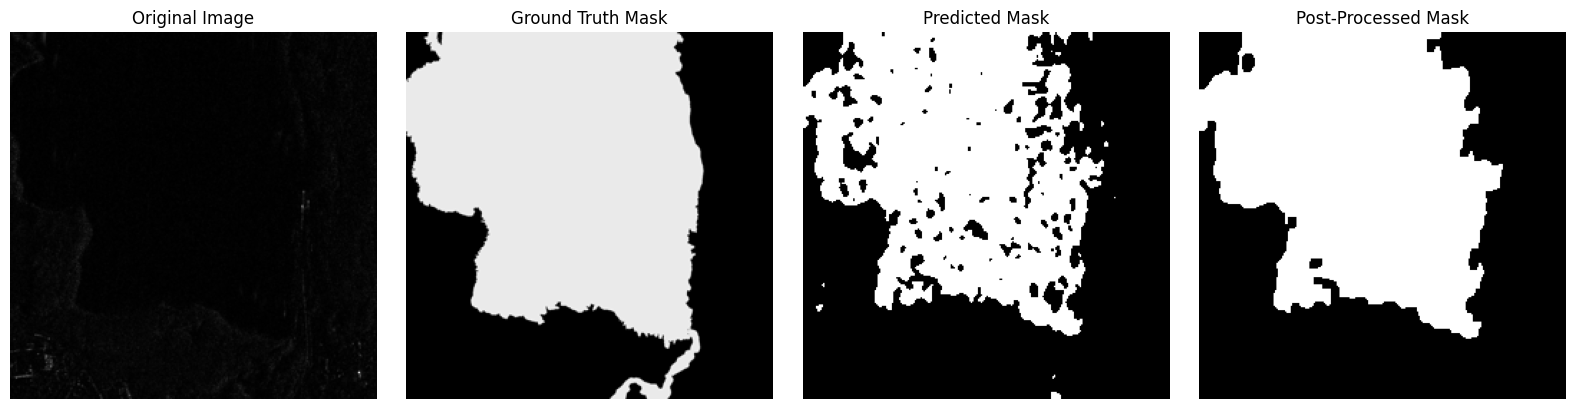

In [ ]:
class SARPostProcessor:
    def __init__(self, min_water_area=50, max_water_area=100000):
        self.min_water_area = min_water_area
        self.max_water_area = max_water_area
    
    def remove_clouds_and_artifacts(self, image, mask, threshold_method='otsu'):
        """
        Enhanced cloud and artifact removal technique with more lenient parameters
        """
        # Convert mask to binary
        binary_mask = (mask > 0.5).astype(np.uint8)
        
        # Apply gentler morphological operations
        kernel = np.ones((2,2), np.uint8)
        denoised_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        
        # Remove isolated pixels and small objects with lower threshold
        cleaned_mask = self._remove_small_objects(denoised_mask, min_size=100)
        
        # Use image intensity to identify potential cloud regions
        if threshold_method == 'otsu':
            # Normalize image for better thresholding
            norm_image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            threshold = filters.threshold_otsu(norm_image)
            
            # Create cloud mask with more lenient threshold
            cloud_mask = norm_image > (threshold * 1.8)
            
            # Remove regions that are likely clouds
            cleaned_mask = np.logical_and(cleaned_mask, ~cloud_mask)
        
        # Fill holes in water bodies
        filled_mask = ndimage.binary_fill_holes(cleaned_mask)
        
        # Final cleaning with smaller kernel
        kernel_final = np.ones((3,3), np.uint8)
        final_mask = cv2.morphologyEx(filled_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel_final)
        
        return final_mask
    
    def _remove_small_objects(self, binary_mask, min_size=100):
        """
        Remove small objects with debug print
        """
        # Label connected components
        labels, num_features = ndimage.label(binary_mask)
        
        # Debug print
        print(f"Number of objects before filtering: {num_features}")
        
        # Remove objects smaller than min_size
        for i in range(1, num_features + 1):
            component = labels == i
            area = np.sum(component)
            if area < min_size:
                binary_mask[component] = 0
        
        # Debug print
        labels_after, num_features_after = ndimage.label(binary_mask)
        print(f"Number of objects after filtering: {num_features_after}")
        
        return binary_mask
    
    def refine_water_boundaries(self, mask):
        """
        Refine water boundaries with gentler parameters
        """
        # Create smaller kernels
        kernel_close = np.ones((5,5), np.uint8)
        kernel_open = np.ones((2,2), np.uint8)
        
        # Close gaps and smooth boundaries
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
        
        # Remove small protrusions
        refined_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel_open)
        
        return refined_mask

    def filter_water_regions(self, mask):
        """
        Filter water regions with debug print
        """
        # Label connected regions
        labeled_mask, num_features = ndimage.label(mask)
        
        # Debug print
        print(f"Total regions before area filtering: {num_features}")
        
        # Compute region properties
        water_regions = []
        for label in range(1, num_features + 1):
            region_mask = labeled_mask == label
            area = np.sum(region_mask)
            
            # Debug print for large regions
            print(f"Region {label} area: {area}")
            
            # Filter based on area constraints
            if self.min_water_area < area < self.max_water_area:
                water_regions.append(region_mask)
        
        # Debug print
        print(f"Regions after area filtering: {len(water_regions)}")
        
        # Reconstruct filtered mask
        filtered_mask = np.zeros_like(mask)
        for region in water_regions:
            filtered_mask = np.logical_or(filtered_mask, region)
        
        return filtered_mask.astype(np.uint8)
    
    def postprocess(self, image, mask):
        """
        Enhanced postprocessing pipeline without intermediate visualizations
        """
        # Remove clouds and artifacts
        cleaned_mask = self.remove_clouds_and_artifacts(image, mask)
        
        # Refine water boundaries
        refined_mask = self.refine_water_boundaries(cleaned_mask)
        
        # Filter water regions
        filtered_mask = self.filter_water_regions(refined_mask)
        
        return image, filtered_mask

def data_generator(img_files, mask_files, batch_size=8, target_size=(256, 256)):
    """Yield batches of images and masks for memory efficiency."""
    while True:
        for start in range(0, len(img_files), batch_size):
            end = min(start + batch_size, len(img_files))
            images, masks = [], []
            for img_path, mask_path in zip(img_files[start:end], mask_files[start:end]):
                # Load and preprocess image and mask
                img = np.array(Image.open(img_path).resize(target_size)).astype('float32') / 255.0
                mask = np.array(Image.open(mask_path).resize(target_size)).astype('float32') / 255.0
                
                img = np.expand_dims(img, axis=-1) if img.ndim == 2 else img
                mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask
                
                images.append(img)
                masks.append(mask)
                
            yield np.array(images), np.array(masks)

def predict_segmentation(image, model):
    """
    Pass the image through the model to get the predicted segmentation mask.
    """
    # Expand dimensions to match model input shape (e.g., [1, H, W, 1])
    input_image = np.expand_dims(image, axis=0)  # Add batch dimension
    predicted_mask = model.predict(input_image, verbose=0)[0, :, :, 0]  # Get the first sample and first channel
    return (predicted_mask > 0.5).astype(np.float32)  # Convert to binary

def visualize_results(original_image, ground_truth_mask, predicted_mask, processed_mask):
    """
    Visualize the original image, ground truth mask, predicted mask, and post-processed mask.
    """
    plt.figure(figsize=(16, 4))

    plt.subplot(141)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(processed_mask, cmap='gray')
    plt.title('Post-Processed Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main pipeline
if __name__ == "__main__":
    # Define paths
    base_path = os.path.join(os.getcwd(), '..', 'data')
    img_path = os.path.join(base_path, 'images')
    mask_path = os.path.join(base_path, 'masks')

    # Get list of image and mask files
    img_files = sorted(glob.glob(os.path.join(img_path, '*.tif')))
    mask_files = sorted(glob.glob(os.path.join(mask_path, '*.tif')))

    if not img_files or not mask_files:
        raise FileNotFoundError("No image or mask files found in the specified directories.")

    # Load the pre-trained model
    model = load_model("unet_new_model.keras", compile=False)

    # Use data_generator to load a batch of resized images and masks
    generator = data_generator(img_files, mask_files, batch_size=1, target_size=(256, 256))
    images, masks = next(generator)  # Get a single batch (batch_size=1)

    # Select the first image and mask
    original_image = images[0, :, :, 0]  # Remove the channel dimension for visualization
    ground_truth_mask = masks[0, :, :, 0]

    # Predict segmentation mask
    predicted_mask = predict_segmentation(original_image, model)

    # Process the mask
    processor = SARPostProcessor(min_water_area=30, max_water_area=100000)
    _, processed_mask = processor.postprocess(original_image, predicted_mask)

    # Visualize results
    visualize_results(original_image, ground_truth_mask, predicted_mask, processed_mask)